In [1]:
import lmdb
import numpy as np
import cv2
import io
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, Bidirectional, LSTM, Dense, Lambda, Rescaling, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# Definir constantes
image_height, image_width = 50, 800
batch_size = 5

def process_images_in_order(directory):
    # Obter todos os subdiretórios e arquivos no diretório principal
    all_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            # Verificar se o arquivo é uma imagem PNG
            if file.lower().endswith(('.png')):
                all_files.append(os.path.join(root, file))
    
    # Ordenar os arquivos em ordem crescente
    all_files.sort()
    return all_files

image_paths = process_images_in_order("processed_imgs")
image_paths_test = process_images_in_order("test_lines")

# Definir função para preprocessar imagens
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Grayscale image
    return image

# Preprocessar imagens e labels
images = [preprocess_image(image_path) for image_path in image_paths]
images_test = [preprocess_image(image_path) for image_path in image_paths_test]
print(len(images_test))

47


In [ ]:
def read_text_files_in_order(directory):
    file_pattern = re.compile(r'texto(\d+)_pagina(\d+)\.txt')
    files = []
    
    # Percorre todos os arquivos no diretório
    for filename in os.listdir(directory):
        # Verifica se o arquivo corresponde ao padrão esperado
        match = file_pattern.match(filename)
        if match:
            X, Y = map(int, match.groups())
            files.append((X, Y, filename))
    
    # Ordena os arquivos por X e Y de forma crescente
    files.sort()
    
    lines = []
    
    # Lê cada arquivo e adiciona suas linhas à lista
    for _, _, filename in files:
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
            for line in f:
                lines.append(line.strip())
    
    return lines

# Exemplo de uso
directory_path = 'img_transcription'
lines = read_text_files_in_order(directory_path)

# Largura máxima de qualquer label no dataset
max_length = max([len(line) for line in lines])

# Criar um set de todos os caracteres únicos nas labels, adicionando o label de 'padding'
all_possible_characters = sorted(set("".join(lines)))

# Criar um mapeamento de caracteres para inteiros e inteiros para caracters
char_to_int = {char: i for i, char in enumerate(all_possible_characters)}
int_to_char = {i: char for char, i in char_to_int.items()}

# Preprocessar labels
encoded_labels = [[char_to_int[char] for char in line] for line in lines]
encoded_labels_padded = pad_sequences(encoded_labels, maxlen=max_length, padding='post', value=len(all_possible_characters))

print(all_possible_characters)
print(len(all_possible_characters))

[' ', '!', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z', '[', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '¼', '½', 'À', 'É', 'à', 'â', 'ç', 'è', 'é', 'ê', 'î', 'ò', 'ô', 'ù', 'û', 'œ', '’']
90


In [4]:
# Crie um Dataset do TensorFlow
dataset = tf.data.Dataset.from_tensor_slices((images, encoded_labels_padded))
print(len(dataset))

# Embaralhe o dataset
dataset = dataset.shuffle(buffer_size=len(images))

# Defina os tamanhos dos datasets de treinamento, validação e teste
train_size = int(0.8 * len(images))
val_size = int(0.1 * len(images))
test_size = len(images) - train_size - val_size

# Divida o dataset em treinamento, validação e teste
train_dataset = dataset.take(train_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
remaining_dataset = dataset.skip(train_size)

validation_dataset = remaining_dataset.take(val_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = remaining_dataset.skip(val_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Verifique os tamanhos dos datasets
print(f'Train size: {train_size}')
print(f'Validation size: {val_size}')
print(f'Test size: {test_size}')

1566
Train size: 1252
Validation size: 156
Test size: 158


In [5]:
# Definir a função Lambda personalizada
def transpose_function(x):
    return tf.transpose(x, perm=[0, 2, 1, 3])

# Definir a camada de entrada
input_data = Input(shape=(image_height, image_width, 1), name='input_image')

# Parâmetros
learning_rate = 0.0005553356219135999
dropout = 0.21976971991582858
lstm1_units = 232
lstm2_units = 222

# Entrada do modelo
x = Rescaling(1./255)(input_data)
x = Lambda(transpose_function, name="transpose")(x)

# Camadas convolucionais
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 1))(x)
x = Dropout(dropout)(x)

# Reshape para formato compatível com RNN
new_shape = (x.shape[1], x.shape[2] * 128)
x = Reshape(target_shape=new_shape)(x)

# Camadas recorrentes
x = Bidirectional(LSTM(lstm1_units, return_sequences=True, dropout=dropout))(x)
x = Bidirectional(LSTM(lstm2_units, return_sequences=True, dropout=dropout))(x)

# Camada de saída softmax
output = Dense(len(all_possible_characters) + 1, activation='softmax', name='output_softmax')(x)

# Entradas adicionais para a perda CTC
labels = Input(name='labels', shape=(None,), dtype='int32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')

# Criar o modelo
model = Model(inputs=input_data, outputs=output, name="OCR_model")

# Compilar o modelo com perda CTC
def ctc_loss(y_true, y_pred):
    input_length = tf.fill([tf.shape(y_pred)[0], 1], tf.shape(y_pred)[1])
    label_length = tf.fill([tf.shape(y_true)[0], 1], max_length)
    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

model.compile(loss=ctc_loss, optimizer=RMSprop(learning_rate=learning_rate))
model.summary()


# Best model yet from optuna:
# {'learning_rate': 0.0008996675553066575, 'dropout_rate': 0.37269073677861625, 'lstm_units1': 69, 'lstm_units2': 192, 'optimizer': 'RMSprop'}

# Best model after 50 cycles:
# {'learning_rate': 0.0005553356219135999, 'dropout_rate': 0.21976971991582858, 'lstm_units1': 232, 'lstm_units2': 222, 'optimizer': 'RMSprop'}.

Model: "OCR_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 50, 800, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 50, 800, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transpose (Lambda)              │ (None, 800, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 800, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 800, 50, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 400, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 400, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 400, 25, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 200, 12, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 200, 12, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200, 12, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 100, 12, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 12, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 1536)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 464)       │     3,283,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 444)       │     1,220,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 100, 91)        │        40,495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,637,439 (17.69 MB)

 Trainable params: 4,636,991 (17.69 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
num_epochs = 40

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         patience=10,
#         verbose=1,
#         restore_best_weights=True),
# ]

# history = model.fit(
#     train_dataset,
#     epochs=num_epochs,
#     validation_data=validation_dataset,
#     callbacks=callbacks
# )

In [ ]:
import pickle
custom_objs = {
    'transpose_function': transpose_function,
    'ctc_loss': ctc_loss  # Garanta que o nome esteja correto conforme registrado
}

loaded_model = load_model('model_increased.keras', custom_objects=custom_objs)

with open('history.pkl', 'rb') as file:
    history_data = pickle.load(file)

In [7]:
# Obter a lista de perdas de validação
val_loss_history = history_data['val_loss']
loss_history = history_data['loss']

# Encontrar o valor mínimo da perda de validação
min_val_loss = min(val_loss_history)
min_loss = min(loss_history)

# Encontrar a época em que ocorreu a perda de validação mínima
best_epoch = val_loss_history.index(min_val_loss)

print(f"Perda de validação mínima: {min_val_loss}")
print(f"Perda de treinamento mínima: {min_loss}")
print(f"Melhor época: {best_epoch + 1}")

Perda de validação mínima: 0.5197240710258484
Perda de treinamento mínima: 1.873329997062683
Melhor época: 39


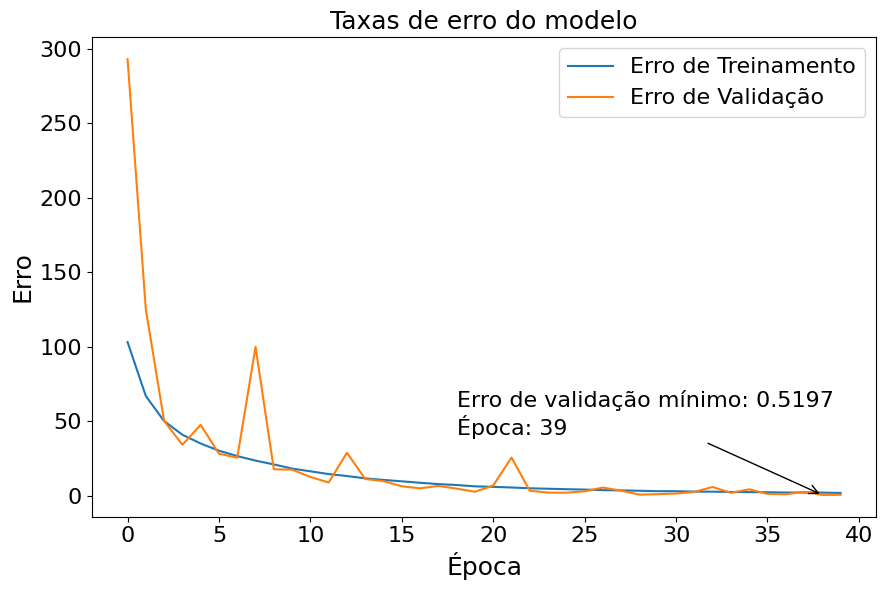

In [ ]:
import pickle
# Para salvar o modelo
# model.save('model_increased_2.keras')  # Salva a arquitetura, os pesos e a configuração de treinamento

# Salvando o objeto `history` em um arquivo .pkl
# with open('history.pkl', 'wb') as file:
#     pickle.dump(history.history, file)

# Achar a época com a menor perda de validação
# best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
best_epoch = history_data['val_loss'].index(min(history_data['val_loss']))


# Plotar histórico de treinamento sem a acurácia
def plot_training_history(history, best_epoch):
    plt.figure(figsize=(9, 6))

    # Plotar valores de perda de treino e de validação
    plt.plot(history['loss'], label='Erro de Treinamento')
    plt.plot(history['val_loss'], label='Erro de Validação')
    plt.title('Taxas de erro do modelo', fontsize=18)  # Aumenta o tamanho do título
    plt.xlabel('Época', fontsize=18)  # Aumenta o tamanho do rótulo do eixo x
    plt.ylabel('Erro', fontsize=18)  # Aumenta o tamanho do rótulo do eixo y
    plt.legend(fontsize=16)  # Aumenta o tamanho da legenda

    # Ajuste do tamanho das fontes dos valores nos eixos
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Exibir a menor perda de validação e a época em que ela ocorreu
    min_val_loss = min(history['val_loss'])
    plt.annotate(
        f'Erro de validação mínimo: {min_val_loss:.4f}\nÉpoca: {best_epoch + 1}',
        xy=(best_epoch, min_val_loss),
        xytext=(best_epoch - 20, min_val_loss + 40),  # Ajustar posição do texto
        fontsize=16,  # Aumenta o tamanho do texto da anotação
        arrowprops=dict(facecolor='black', arrowstyle='->')
    )

    plt.tight_layout()
    plt.show()


# plot_training_history(history, best_epoch)
plot_training_history(history_data, best_epoch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


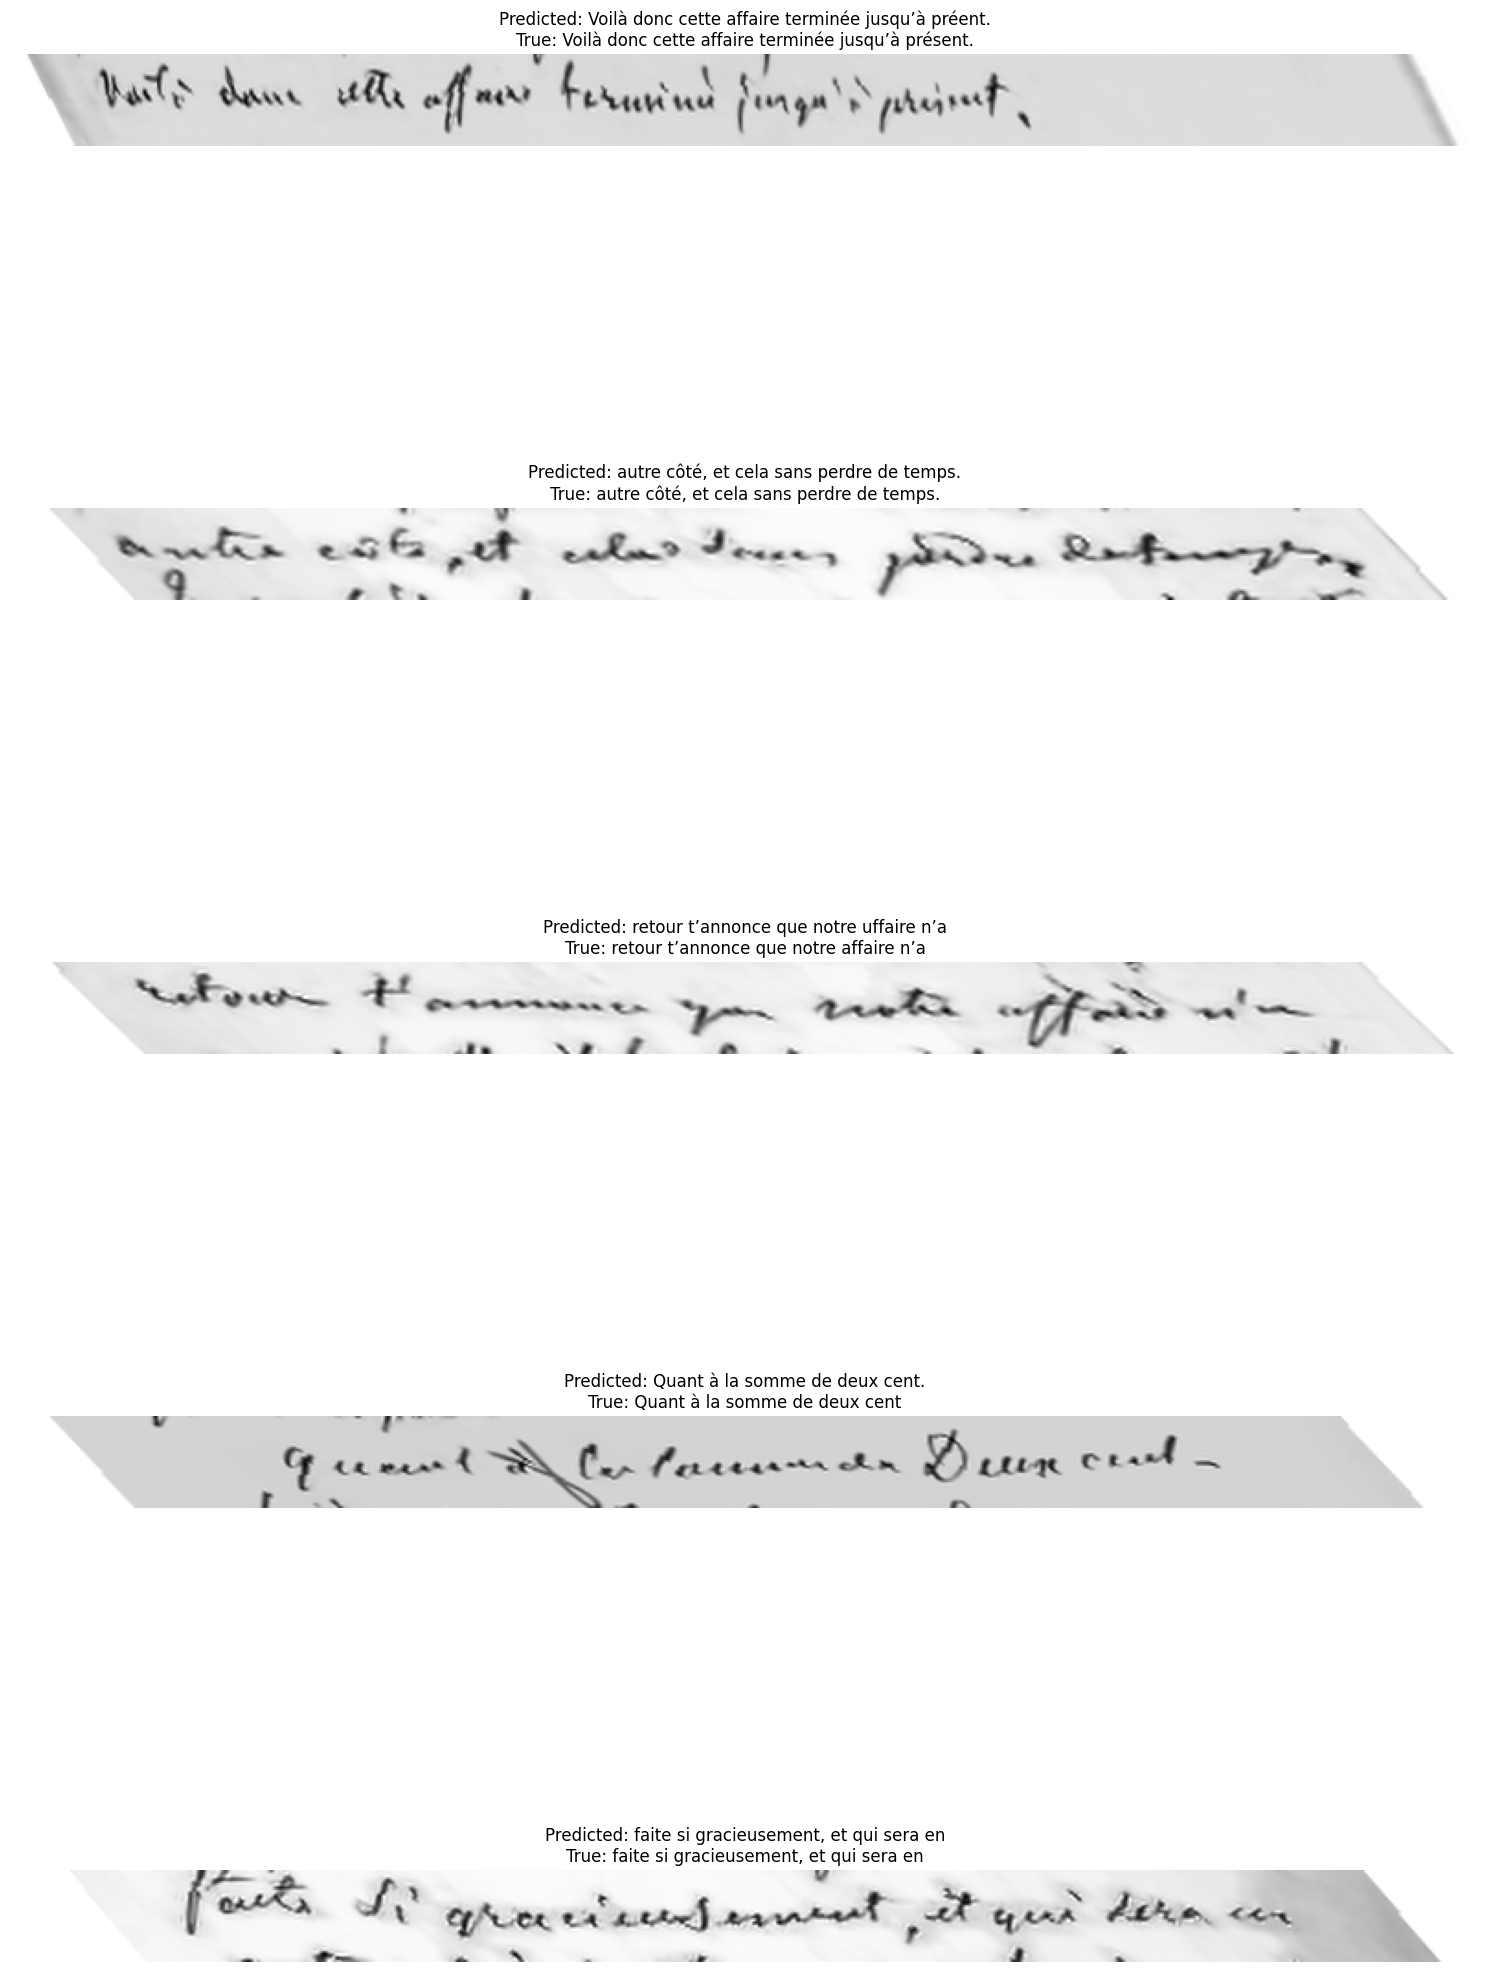

['Voilà donc cette affaire terminée jusqu’à préent.', 'autre côté, et cela sans perdre de temps.', 'retour t’annonce que notre uffaire n’a', 'Quant à la somme de deux cent.', 'faite si gracieusement, et qui sera en']
['Voilà donc cette affaire terminée jusqu’à présent.', 'autre côté, et cela sans perdre de temps.', 'retour t’annonce que notre affaire n’a', 'Quant à la somme de deux cent', 'faite si gracieusement, et qui sera en']
['Voilà', 'donc', 'cette', 'affaire', 'terminée', 'jusqu’à', 'préent.', 'autre', 'côté,', 'et', 'cela', 'sans', 'perdre', 'de', 'temps.', 'retour', 't’annonce', 'que', 'notre', 'uffaire', 'n’a', 'Quant', 'à', 'la', 'somme', 'de', 'deux', 'cent.', 'faite', 'si', 'gracieusement,', 'et', 'qui', 'sera', 'en']
['Voilà', 'donc', 'cette', 'affaire', 'terminée', 'jusqu’à', 'présent.', 'autre', 'côté,', 'et', 'cela', 'sans', 'perdre', 'de', 'temps.', 'retour', 't’annonce', 'que', 'notre', 'affaire', 'n’a', 'Quant', 'à', 'la', 'somme', 'de', 'deux', 'cent', 'faite', 'si

In [10]:
# Função para calcular a CER
def cer(y_true, y_pred):
    errors = sum(1 for a, b in zip(y_true, y_pred) if a != b)
    return errors / len(y_true)

# Função para calcular a WER
def wer(y_true, y_pred):
    y_true_words = y_true.split()
    y_pred_words = y_pred.split()
    errors = sum(1 for a, b in zip(y_true_words, y_pred_words) if a != b)
    return errors / len(y_true_words)

def calculate_metrics(y_true, y_pred):
    # Achatando as listas em nível de token
    y_true_flat = [token for seq in y_true for token in seq.split()]
    y_pred_flat = [token for seq in y_pred for token in seq.split()]
    print(y_pred_flat)
    print(y_true_flat)
    

    # Verificar se os tamanhos são os mesmos após o achatamento
    min_length = min(len(y_true_flat), len(y_pred_flat))
    y_true_flat = y_true_flat[:min_length]
    y_pred_flat = y_pred_flat[:min_length]

    # Calcular métricas
    precision = precision_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)

    return precision, recall, f1

# Função para visualizar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    # Calcular a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def decode_and_visualize_samples(model, dataset, int_to_char, num_samples=5):
    """
    Decode and visualize random samples from a dataset using the provided model.

    Args:
        model (tf.keras.Model): The CRNN model.
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        int_to_char (dict): A mapping from integer labels to characters.
        num_samples (int): The number of samples to visualize.

    Returns:
        None
    """
    y_true=[]
    y_pred=[]

    # Adiciona o mapeamento do "blank label" se não existir
    if 90 not in int_to_char:
        int_to_char[90] = ''

    # Create an iterator for the dataset
    dataset_iter = iter(dataset)

    # Create a subplot grid
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5 * num_samples))

    # Iterate through the random samples, decode, and visualize them
    for i in range(num_samples):
        image, label = next(dataset_iter)

        # Make predictions using the model
        predictions = model.predict(image)
        
        # Decode the predictions using CTC decode
        decoded, _ = tf.keras.backend.ctc_decode(predictions, input_length=tf.fill((tf.shape(predictions)[0],), tf.shape(predictions)[1]), greedy=True)

        # Convert decoded labels to characters
        decoded_labels = [int_to_char.get(int(x), '') for x in decoded[0][0].numpy()]

        # Convert the true labels to characters
        true_labels = [int_to_char.get(int(x), '') for x in label[0].numpy() if int(x) in int_to_char]

        y_pred.append(''.join(decoded_labels))
        y_true.append(''.join(true_labels))

        # Display the image and decoded label
        axes[i].imshow(image[0, :, :, 0], cmap='gray')
        axes[i].set_title("Predicted: " + ''.join(decoded_labels) + "\nTrue: " + ''.join(true_labels))
        axes[i].axis('off')

    # Adjust spacing and display the grid
    plt.tight_layout()
    plt.show()

    return y_pred, y_true

# Exemplo de uso:
y_pred, y_true = decode_and_visualize_samples(loaded_model, test_dataset, int_to_char, num_samples=5)

print(y_pred)
print(y_true)

cer_value = cer(y_true[0], y_pred[0])
wer_value = wer(y_true[0], y_pred[0])
precision, recall, f1 = calculate_metrics(y_true, y_pred)

print(f"CER: {cer_value}")
print(f"WER: {wer_value}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Extração de caracteres de listas de strings
y_true_chars = [char for seq in y_true for char in seq]
y_pred_chars = [char for seq in y_pred for char in seq]

# Igualar comprimentos para evitar erros
min_length = min(len(y_true_chars), len(y_pred_chars))
y_true_chars = y_true_chars[:min_length]
y_pred_chars = y_pred_chars[:min_length]

# plot_confusion_matrix(y_true_chars, y_pred_chars)

In [9]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from jiwer import wer, cer

def decode_full_dataset(model, dataset, int_to_char):
    """
    Decode predictions for the entire test dataset.

    Args:
        model (tf.keras.Model): The CRNN model.
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        int_to_char (dict): A mapping from integer labels to characters.

    Returns:
        y_pred (list): List of predicted texts.
        y_true (list): List of true texts.
    """
    y_true = []
    y_pred = []

    # Adiciona o mapeamento do "blank label" se não existir
    if 90 not in int_to_char:
        int_to_char[90] = ''

    # Itera sobre o dataset para prever e coletar os textos preditos e reais
    for image, label in dataset:
        # Fazer previsões usando o modelo
        predictions = model.predict(image)

        # Decodificar previsões usando CTC decode
        decoded, _ = tf.keras.backend.ctc_decode(predictions, input_length=tf.fill((tf.shape(predictions)[0],), tf.shape(predictions)[1]), greedy=True)

        # Converter previsões decodificadas em caracteres
        decoded_labels = [''.join([int_to_char.get(int(x), '') for x in seq if int(x) in int_to_char]) for seq in decoded[0]]
        
        # Converter rótulos verdadeiros em caracteres
        true_labels = [''.join([int_to_char.get(int(x), '') for x in seq.numpy() if int(x) in int_to_char]) for seq in label]

        # Adicionar à lista de predições e rótulos verdadeiros
        y_pred.extend(decoded_labels)
        y_true.extend(true_labels)

    return y_pred, y_true

# Decodificar e calcular métricas para o conjunto de teste completo
y_pred, y_true = decode_full_dataset(loaded_model, test_dataset, int_to_char)

# Exibir o texto predito e o real para cada amostra
for true_text, pred_text in zip(y_true, y_pred):
    print(f"Real: {true_text}, Predito: {pred_text}")

# Calcular WER e CER para cada par de textos
wer_values = [wer(true, pred) for true, pred in zip(y_true, y_pred)]
cer_values = [cer(true, pred) for true, pred in zip(y_true, y_pred)]

# Calcular médias das métricas
avg_wer = sum(wer_values) / len(wer_values)
avg_cer = sum(cer_values) / len(cer_values)

# Exibir resultados
print("Valores de WER para cada frase:", wer_values)
print("Valores de CER para cada frase:", cer_values)
print(f"Média do WER: {avg_wer:}")
print(f"Média do CER: {avg_cer:}")

# Calcular e exibir CER e WER para o conjunto completo
# cer_values = [cer(t, p) for t, p in zip(y_true, y_pred)]
# wer_values = [wer(t, p) for t, p in zip(y_true, y_pred)]
# avg_cer = sum(cer_values) / len(cer_values)
# avg_wer = sum(wer_values) / len(wer_values)
# print(f"\nMédia do CER: {avg_cer:.4f}")
# print(f"Média do WER: {avg_wer:.4f}")


# Inicialize a função de suavização
smoothing_fn = SmoothingFunction().method1

# Função para calcular o BLEU Score com suavização
def calculate_bleu_score(y_true, y_pred):
    bleu_scores = []
    for true, pred in zip(y_true, y_pred):
        # Tokenize as frases de referência e preditas
        reference = [true.split()]
        candidate = pred.split()
        
        # Calcular o BLEU Score com suavização
        score = sentence_bleu(reference, candidate, smoothing_function=smoothing_fn)
        bleu_scores.append(score)
    
    # Retornar a média dos BLEU Scores
    return sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0

def calculate_all_bleu(y_true, y_pred):
    bleu_scores = []
    for true, pred in zip(y_true, y_pred):
        # Tokenize as frases de referência e preditas
        reference = [true.split()]
        candidate = pred.split()
        
        # Calcular o BLEU Score com suavização
        score = sentence_bleu(reference, candidate, smoothing_function=smoothing_fn)
        bleu_scores.append(score)
    
    # Retornar a média dos BLEU Scores
    return bleu_scores

# Exemplo de uso
bleu_score = calculate_bleu_score(y_true, y_pred)
print(f"BLEU Score médio para o conjunto de teste: {bleu_score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

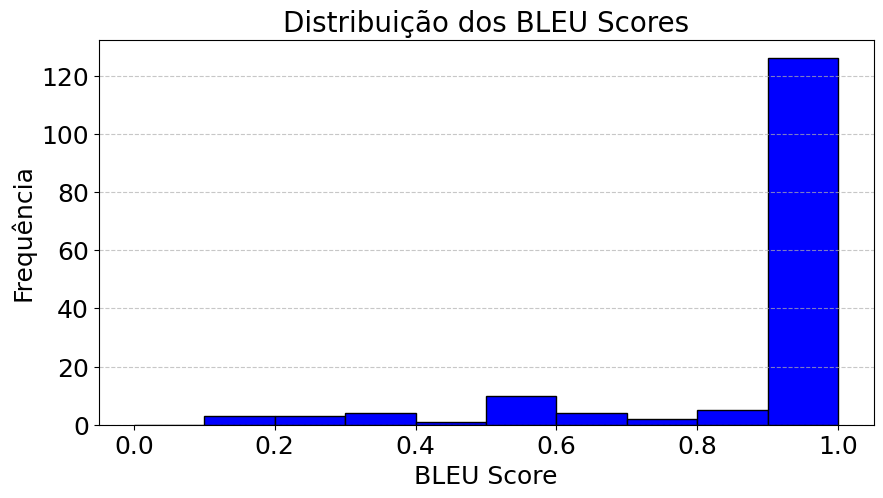

In [11]:
# Plotar
all_bleu = calculate_all_bleu(y_true, y_pred)

# Gerar os valores para o histograma
bins = np.arange(0, 1.1, 0.1)  # Intervalos de 0.1
frequencies, edges = np.histogram(all_bleu, bins=bins)

# Alternar cores
colors = ['red' if i % 2 == 0 else 'blue' for i in range(len(frequencies))]


# Plotar o histograma manualmente para alternar as cores
plt.figure(figsize=(10, 5))
for i in range(len(frequencies)):
    plt.bar(edges[i], frequencies[i], width=edges[i + 1] - edges[i], color='blue', edgecolor='black', align='edge')

# Personalizar os tamanhos das fontes nos eixos
plt.xticks(fontsize=18)  # Aumenta o tamanho da fonte dos números no eixo x
plt.yticks(fontsize=18)  # Aumenta o tamanho da fonte dos números no eixo y
plt.title('Distribuição dos BLEU Scores', fontsize=20)
plt.xlabel('BLEU Score', fontsize=18)
plt.ylabel('Frequência', fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

0.024085794655414904
0.0044266866800751255
[]


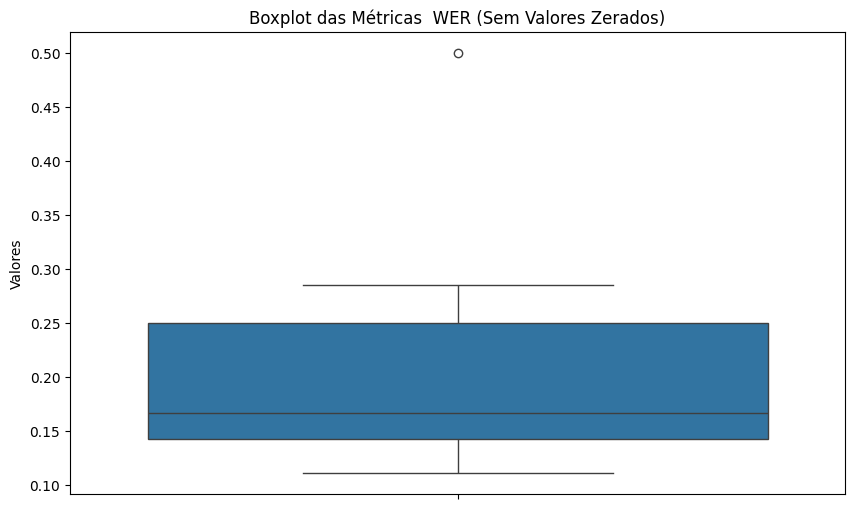

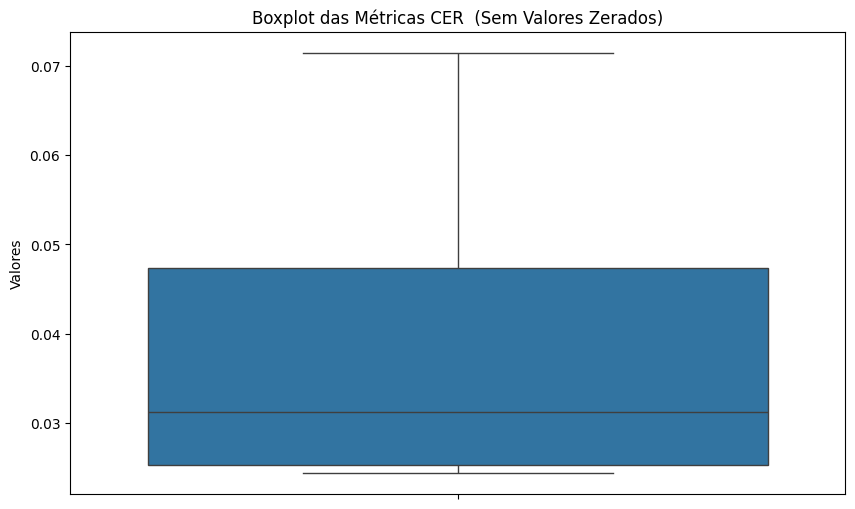

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Listas para armazenar os valores de CER e WER para cada amostra
cer_new = []
wer_new = []

# Iterar por todas as amostras no conjunto de teste
for true, pred in zip(y_true, y_pred):
    # Calcular CER e WER para cada par de previsão e referência
    cer_new.append(cer(true, pred))
    wer_new.append(wer(true, pred))

# Criar um DataFrame para organizar os dados
data = pd.DataFrame({
    "CER": cer_new,
    "WER": wer_new
})

# Limitar valores para melhorar a visualização
# max_limit = 0.5  # Ajuste conforme necessário
# data_clipped = data.clip(upper=max_limit)

# print(data_clipped)

# plt.figure(figsize=(10, 6))
# sns.boxplot(data=data_clipped)
# plt.title("Boxplot das Métricas CER e WER (Outliers Limitados)")
# plt.ylabel("Valores (Limitados a 0.5)")
# plt.show()

# Remover temporariamente os valores iguais a 0
wer_no_zeros = [x for x in wer_new if x != 0]
cer_no_zeros = [x for x in cer_new if x != 0]

# Criar dataframe com os valores não nulos
data_no_zeros = pd.DataFrame({"WER (Sem Zeros)": wer_no_zeros, "CER (Sem Zeros)": cer_no_zeros})

avg_wer_new = sum(wer_new) / len(wer_new)
avg_cer_new = sum(cer_new) / len(cer_new)

print(avg_wer_new)
print(avg_cer_new)

std_sample = np.std(data, ddof=1)

new_list = []
# for i in wer_no_zeros:
#     new_list.append((wer_no_zeros[i] - avg_wer_new)/std_sample)
#     i = i+1

print(new_list)

# print(data_no_zeros)

# Plotar boxplot sem zeros
plt.figure(figsize=(10, 6))
sns.boxplot(data=wer_no_zeros)
plt.title("Boxplot das Métricas  WER (Sem Valores Zerados)")
plt.ylabel("Valores")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=cer_no_zeros)
plt.title("Boxplot das Métricas CER  (Sem Valores Zerados)")
plt.ylabel("Valores")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


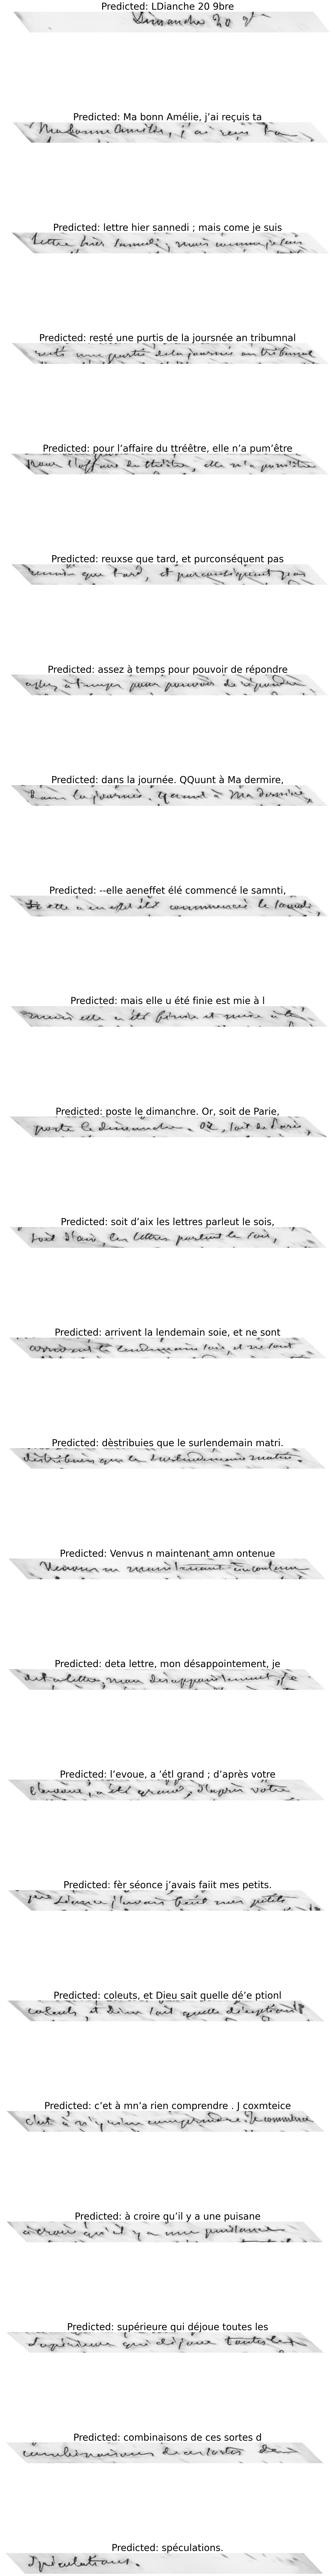

LDianche 20 9bre Ma bonn Amélie, j’ai reçuis ta lettre hier sannedi ; mais come je suis resté une purtis de la joursnée an tribumnal pour l’affaire du ttréêtre, elle n’a pum’être reuxse que tard, et purconséquent pas assez à temps pour pouvoir de répondre dans la journée. QQuunt à Ma dermire, --elle aeneffet élé commencé le samnti, mais elle u été finie est mie à l poste le dimanchre. Or, soit de Parie, soit d’aix les lettres parleut le sois, arrivent la lendemain soie, et ne sont dèstribuies que le surlendemain matri. Venvus n maintenant amn ontenue deta lettre, mon désappointement, je l’evoue, a ’étl grand ; d’après votre fèr séonce j’avais faiit mes petits. coleuts, et Dieu sait quelle dé’e ptionl c’et à mn’a rien comprendre . J coxmteice à croire qu’il y a une puisane supérieure qui déjoue toutes les combinaisons de ces sortes d spéculations.


In [ ]:
def predict_test(model, dataset, int_to_char, num_samples=5):
    """
    Decode and visualize random samples from a dataset using the provided model.

    Args:
        model (tf.keras.Model): The CRNN model.
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        int_to_char (dict): A mapping from integer labels to characters.
        num_samples (int): The number of samples to visualize.

    Returns:
        None
    """

    # Adiciona o mapeamento do "blank label" se não existir
    if 90 not in int_to_char:
        int_to_char[90] = ''

    # Criar um iterador para o dataset
    dataset_iter = iter(dataset)

    # Criar um grid de subplots
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5 * num_samples))

    y_pred=[]

    # Iterar sobre amostras aleatórias, decodificá-las e vizualizá-las 
    for i in range(num_samples):
        image = next(dataset_iter)

        # Fazer predições usando o modelo
        predictions = model.predict(image)
        
        # Decodificar as predições usando o decodificador CTC
        decoded, _ = tf.keras.backend.ctc_decode(predictions, input_length=tf.fill((tf.shape(predictions)[0],), tf.shape(predictions)[1]), greedy=True)

        # Converter as labels decodificadas em caracteres
        decoded_labels = [int_to_char.get(int(x), '') for x in decoded[0][0].numpy()]

        y_pred.append(''.join(decoded_labels))

        # Exibir a imagem e a label decodificada
        axes[i].imshow(image[0, :, :, 0], cmap='gray')
        axes[i].set_title("Predicted: " + ''.join(decoded_labels), fontsize=30)  # Ajuste do tamanho da fonte
        axes[i].axis('off')

    # Ajustar espaçamento e exibir o grid
    plt.tight_layout()
    plt.show()

    return y_pred

test_ds = tf.data.Dataset.from_tensor_slices(images_test)

test_ds = test_ds.batch(1)

# Embaralhe o dataset
# test_ds = test_ds.shuffle(buffer_size=len(images_test))

predictions = predict_test(loaded_model, test_ds, int_to_char, num_samples=24)

text_prediction = " ".join(predictions)

print(text_prediction)

In [13]:
import google.generativeai as genai

french_test="jsqu'a ce qu je l'aie tnu; car il"

prompt='Give me a suggestion of correction for the following line of text in french from the 20th century: "'+text_prediction+'"'
print(prompt)

genai.configure(api_key='')

model = genai.GenerativeModel()
response = model.generate_content(prompt)

print(response.text)

Give me a suggestion of correction for the following line of text in french from the 20th century: "LDianche 20 9bre Ma bonn Amélie, j’ai reçuis ta lettre hier sannedi ; mais come je suis resté une purtis de la joursnée an tribumnal pour l’affaire du ttréêtre, elle n’a pum’être reuxse que tard, et purconséquent pas assez à temps pour pouvoir de répondre dans la journée. QQuunt à Ma dermire, --elle aeneffet élé commencé le samnti, mais elle u été finie est mie à l poste le dimanchre. Or, soit de Parie, soit d’aix les lettres parleut le sois, arrivent la lendemain soie, et ne sont dèstribuies que le surlendemain matri. Venvus n maintenant amn ontenue deta lettre, mon désappointement, je l’evoue, a ’étl grand ; d’après votre fèr séonce j’avais faiit mes petits. coleuts, et Dieu sait quelle dé’e ptionl c’et à mn’a rien comprendre . J coxmteice à croire qu’il y a une puisane supérieure qui déjoue toutes les combinaisons de ces sortes d spéculations."
**Corrections :**

* "LDianche" -> "Dima

In [ ]:
import optuna

def create_model(trial):
    image_height, image_width = 50, 800  # Defina suas dimensões de imagem
    num_classes = len(all_possible_characters) + 1

    # Hiperparâmetros a serem otimizados
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    dropout_rate1 = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    dropout_rate2 = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    dropout_rate3 = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    lstm_units1 = trial.suggest_int('lstm_units1', 64, 256)
    lstm_units2 = trial.suggest_int('lstm_units2', 64, 256)
    optimizer_name = trial.suggest_categorical('optimizer', ['RMSprop', 'Adam'])

    # Definir o layer de input
    input_data = Input(shape=(image_height, image_width, 1), name='input_image')

    # Entrada do modelo
    x = Rescaling(1./255)(input_data)
    x = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]), name="transpose")(x)
    
    # Camadas convolucionais
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 1))(x)
    x = Dropout(dropout_rate1)(x)
    
    # Reshape para formato compatível com RNN
    new_shape = (x.shape[1], x.shape[2] * 128)
    x = Reshape(target_shape=new_shape)(x)
    
    # Camadas recorrentes
    x = Bidirectional(LSTM(lstm_units1, return_sequences=True, dropout=dropout_rate2))(x)
    x = Bidirectional(LSTM(lstm_units2, return_sequences=True, dropout=dropout_rate3))(x)
    
    # Camada de saída softmax
    output = Dense(num_classes, activation='softmax', name='output_softmax')(x)
    
    # Entradas adicionais para a perda CTC
    labels = Input(name='labels', shape=(None,), dtype='int32')
    input_length = Input(name='input_length', shape=(1,), dtype='int64')
    label_length = Input(name='label_length', shape=(1,), dtype='int64')
    
    # Criar o modelo
    model = Model(inputs=input_data, outputs=output, name="OCR_model")
    
    # Compilar o modelo com perda CTC
    def ctc_loss(y_true, y_pred):
        input_length = tf.fill([tf.shape(y_pred)[0], 1], tf.shape(y_pred)[1])
        label_length = tf.fill([tf.shape(y_true)[0], 1], max_length)
        loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
        return loss

    if optimizer_name == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss=ctc_loss, optimizer=optimizer)

    return model


In [51]:
def objective(trial):
    model = create_model(trial)
    
    # Número de épocas
    num_epochs = 25
    
    # Carregar dados
    train_data = train_dataset
    val_data = validation_dataset
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1,
            restore_best_weights=True),
    ]
    
    # Treinamento do modelo
    history = model.fit(
        train_data,
        epochs=num_epochs,
        validation_data=val_data,
        callbacks=callbacks
    )
    
    # Retorna a perda de validação mínima obtida durante o treinamento
    val_loss = min(history.history['val_loss'])
    
    return val_loss

In [52]:
# Cria o estudo e define o número de trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Exibe os melhores hiperparâmetros encontrados
print('Best trial:')
trial = study.best_trial

print(' Value: ', trial.value)
print(' Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-06-05 15:12:54,855] A new study created in memory with name: no-name-f61304d4-ab31-43d6-9892-7cc51495821f


Epoch 1/25


C:\Users\Fernando Veizaga\AppData\Local\Temp\ipykernel_16132\1993278531.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\Fernando Veizaga\AppData\Local\Temp\ipykernel_16132\1993278531.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate1 = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
C:\Users\Fernando Veizaga\AppData\Local\Temp\ipykernel_16132\1993278531.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate2 = trial.suggest_uniform('dropout

199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 163ms/step - loss: 153.3367 - val_loss: 117.9387
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 155ms/step - loss: 106.5609 - val_loss: 136.9562
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 155ms/step - loss: 105.9562 - val_loss: 98.0184
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 154ms/step - loss: 100.2581 - val_loss: 92.7097
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 154ms/step - loss: 89.7897 - val_loss: 82.1244
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 154ms/step - loss: 80.5848 - val_loss: 76.0706
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 155ms/step - loss: 71.5059 - val_loss: 61.8413
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 65.4219 - val_loss: 61.6525
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 157ms/step - loss: 58.4661 - val_loss: 54.5308
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 53.7510 - val_loss: 49.6022
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 154ms/step - loss: 50.8565 - val_loss: 46.8810
Ep

[I 2024-06-05 15:25:57,888] Trial 0 finished with value: 23.235692977905273 and parameters: {'learning_rate': 0.00019696781090181273, 'dropout_rate': 0.3096630570589566, 'lstm_units1': 156, 'lstm_units2': 130, 'optimizer': 'Adam'}. Best is trial 0 with value: 23.235692977905273.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - loss: 132.6643 - val_loss: 177.0966
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step - loss: 104.5548 - val_loss: 182.7434
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - loss: 95.4048 - val_loss: 89.9780
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - loss: 85.5201 - val_loss: 79.4919
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - loss: 79.0945 - val_loss: 70.5707
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 73.3493 - val_loss: 66.4872
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - loss: 68.7053 - val_loss: 61.1376
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - loss: 62.9118 - val_loss: 58.3114
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - loss: 56.4244 - val_loss: 54.8063
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - loss: 54.3262 - val_loss: 45.7623
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - loss: 51.9258 - val_loss: 4

[I 2024-06-05 15:37:59,928] Trial 1 finished with value: 24.641460418701172 and parameters: {'learning_rate': 0.0001485724324716088, 'dropout_rate': 0.28567629716647114, 'lstm_units1': 138, 'lstm_units2': 191, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 23.235692977905273.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 170ms/step - loss: 252.1611 - val_loss: 231.9632
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - loss: 122.1634 - val_loss: 115.9700
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - loss: 112.8202 - val_loss: 109.7870
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - loss: 107.3998 - val_loss: 107.5253
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 32s 163ms/step - loss: 107.2865 - val_loss: 106.4279
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - loss: 105.3836 - val_loss: 107.5260
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - loss: 106.3586 - val_loss: 107.1464
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - loss: 104.5703 - val_loss: 105.8413
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - loss: 105.1808 - val_loss: 105.3731
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - loss: 105.9497 - val_loss: 105.4680
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - loss: 105.2

[I 2024-06-05 15:46:46,934] Trial 2 finished with value: 102.89517974853516 and parameters: {'learning_rate': 2.316699388296428e-05, 'dropout_rate': 0.4190011008526498, 'lstm_units1': 162, 'lstm_units2': 110, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 23.235692977905273.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 142ms/step - loss: 153.5514 - val_loss: 115.5278
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - loss: 105.7857 - val_loss: 136.1348
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - loss: 103.3064 - val_loss: 106.2103
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - loss: 103.5712 - val_loss: 98.6486
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - loss: 97.4491 - val_loss: 90.3095
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - loss: 90.4444 - val_loss: 87.5584
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - loss: 86.7657 - val_loss: 81.5594
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - loss: 82.4965 - val_loss: 78.2453
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - loss: 79.2945 - val_loss: 73.9488
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - loss: 77.2890 - val_loss: 72.6161
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - loss: 74.3608 - val_loss

[I 2024-06-05 15:58:19,553] Trial 3 finished with value: 43.672122955322266 and parameters: {'learning_rate': 8.15088384532873e-05, 'dropout_rate': 0.34988924508362584, 'lstm_units1': 130, 'lstm_units2': 204, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 23.235692977905273.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - loss: 204.5154 - val_loss: 117.9250
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - loss: 107.3494 - val_loss: 114.1284
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - loss: 107.5272 - val_loss: 107.8399
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step - loss: 104.1480 - val_loss: 105.9078
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - loss: 105.1504 - val_loss: 104.3152
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - loss: 105.5189 - val_loss: 104.2597
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - loss: 103.9436 - val_loss: 103.1164
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - loss: 105.3128 - val_loss: 103.0589
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - loss: 102.8948 - val_loss: 98.6671
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - loss: 101.4623 - val_loss: 97.3062
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - loss: 99.5858

[I 2024-06-05 16:09:00,292] Trial 4 finished with value: 69.60888671875 and parameters: {'learning_rate': 4.403529107698334e-05, 'dropout_rate': 0.4580116830331591, 'lstm_units1': 115, 'lstm_units2': 206, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 23.235692977905273.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - loss: 242.5210 - val_loss: 205.5060
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - loss: 116.6622 - val_loss: 120.7711
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - loss: 108.3448 - val_loss: 108.3370
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 106.4474 - val_loss: 105.1875
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - loss: 106.1404 - val_loss: 106.3083
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - loss: 105.5080 - val_loss: 104.8771
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - loss: 104.1592 - val_loss: 105.6408
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - loss: 103.4852 - val_loss: 105.8027
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - loss: 105.6421 - val_loss: 106.1385
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - loss: 104.5741 - val_loss: 104.7887
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 105.4

[I 2024-06-05 16:21:07,147] Trial 5 finished with value: 84.69142150878906 and parameters: {'learning_rate': 2.024503930295414e-05, 'dropout_rate': 0.3739848788842513, 'lstm_units1': 142, 'lstm_units2': 200, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 23.235692977905273.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - loss: 270.0854 - val_loss: 260.4293
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - loss: 123.0098 - val_loss: 113.3890
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 110.2696 - val_loss: 113.9262
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - loss: 108.3303 - val_loss: 108.6310
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - loss: 107.4028 - val_loss: 105.8289
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - loss: 107.9632 - val_loss: 106.4761
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - loss: 106.5963 - val_loss: 104.7925
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - loss: 106.2152 - val_loss: 106.3975
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 106.4937 - val_loss: 104.1092
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - loss: 105.7370 - val_loss: 105.4285
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - loss: 105.8

[I 2024-06-05 16:36:56,733] Trial 6 finished with value: 95.1267318725586 and parameters: {'learning_rate': 2.078356182128661e-05, 'dropout_rate': 0.45108124840182223, 'lstm_units1': 179, 'lstm_units2': 192, 'optimizer': 'Adam'}. Best is trial 0 with value: 23.235692977905273.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - loss: 127.5282 - val_loss: 183.7452
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - loss: 101.9947 - val_loss: 254.4643
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - loss: 86.5162 - val_loss: 93.3488
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - loss: 79.9251 - val_loss: 72.1792
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - loss: 71.0251 - val_loss: 70.2977
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - loss: 66.2521 - val_loss: 60.7658
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - loss: 59.2141 - val_loss: 54.9334
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - loss: 56.0379 - val_loss: 53.3615
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - loss: 51.9820 - val_loss: 48.3442
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - loss: 49.9416 - val_loss: 46.1506
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - loss: 47.4514 - val_loss: 5

[I 2024-06-05 16:46:39,137] Trial 7 finished with value: 25.521793365478516 and parameters: {'learning_rate': 0.0004812533852248887, 'dropout_rate': 0.47105262741107, 'lstm_units1': 106, 'lstm_units2': 139, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 23.235692977905273.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - loss: 179.4316 - val_loss: 184.0731
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 107.3163 - val_loss: 121.3688
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 148ms/step - loss: 107.3766 - val_loss: 107.7636
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 104.4030 - val_loss: 104.8315
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 103.5151 - val_loss: 101.4570
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 102.5974 - val_loss: 99.3521
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 97.7440 - val_loss: 91.3987
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 93.7514 - val_loss: 88.0151
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 90.1279 - val_loss: 86.3630
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 86.6292 - val_loss: 86.2904
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 85.6918 - val_

[I 2024-06-05 16:58:40,524] Trial 8 finished with value: 53.61094284057617 and parameters: {'learning_rate': 4.652514476016778e-05, 'dropout_rate': 0.31488183059887465, 'lstm_units1': 144, 'lstm_units2': 202, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 23.235692977905273.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 51s 238ms/step - loss: 245.9946 - val_loss: 308.1424
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 120.0887 - val_loss: 116.2451
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 110.3600 - val_loss: 108.8719
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 107.3910 - val_loss: 106.8802
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - loss: 106.6320 - val_loss: 104.7311
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 107.6727 - val_loss: 107.2837
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - loss: 106.3829 - val_loss: 106.8971
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 104.0579 - val_loss: 104.7640
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 104.6768 - val_loss: 105.6693
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 105.8745 - val_loss: 104.3260
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 105.5

[I 2024-06-05 17:18:21,141] Trial 9 finished with value: 83.68095397949219 and parameters: {'learning_rate': 1.9981719503915653e-05, 'dropout_rate': 0.2983754977183566, 'lstm_units1': 235, 'lstm_units2': 135, 'optimizer': 'Adam'}. Best is trial 0 with value: 23.235692977905273.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 133.6096 - val_loss: 113.3490
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 106.1156 - val_loss: 148.3596
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - loss: 101.1611 - val_loss: 95.8147
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 84.9612 - val_loss: 96.5518
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - loss: 68.9592 - val_loss: 65.2671
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 56.6949 - val_loss: 54.2642
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 50.2235 - val_loss: 66.6092
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - loss: 46.9793 - val_loss: 42.8394
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 43.4684 - val_loss: 41.7068
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - loss: 39.7795 - val_loss: 57.4272
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 37.8713 - val_loss: 34.1629
Epo

[I 2024-06-05 17:25:55,344] Trial 10 finished with value: 19.110193252563477 and parameters: {'learning_rate': 0.0009840665331179858, 'dropout_rate': 0.2107605418592369, 'lstm_units1': 65, 'lstm_units2': 68, 'optimizer': 'Adam'}. Best is trial 10 with value: 19.110193252563477.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 134.4564 - val_loss: 110.2118
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 104.9965 - val_loss: 129.1400
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 103.4362 - val_loss: 99.6707
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 91.7529 - val_loss: 96.6996
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - loss: 76.4340 - val_loss: 68.8971
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 63.7634 - val_loss: 102.3504
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 56.9491 - val_loss: 51.3935
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 50.2210 - val_loss: 60.4547
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 45.8903 - val_loss: 61.5671
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 43.6852 - val_loss: 39.7603
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 41.4162 - val_loss: 36.5612
Ep

[I 2024-06-05 17:33:43,720] Trial 11 finished with value: 17.91425895690918 and parameters: {'learning_rate': 0.000711141840527579, 'dropout_rate': 0.2040554263607048, 'lstm_units1': 70, 'lstm_units2': 65, 'optimizer': 'Adam'}. Best is trial 11 with value: 17.91425895690918.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - loss: 130.2599 - val_loss: 118.1369
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 106.4301 - val_loss: 146.4406
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 100.3139 - val_loss: 86.1494
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 77.5967 - val_loss: 74.0682
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 64.0967 - val_loss: 102.6500
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 53.7246 - val_loss: 54.5252
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 48.0069 - val_loss: 46.2594
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 44.1628 - val_loss: 43.7007
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 41.0840 - val_loss: 41.1374
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 38.7647 - val_loss: 38.6702
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 35.3372 - val_loss: 45.9353
E

[I 2024-06-05 17:41:57,337] Trial 12 finished with value: 17.28160285949707 and parameters: {'learning_rate': 0.0009873703580709349, 'dropout_rate': 0.20232853494282074, 'lstm_units1': 79, 'lstm_units2': 66, 'optimizer': 'Adam'}. Best is trial 12 with value: 17.28160285949707.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 138.2719 - val_loss: 112.8760
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 105.8603 - val_loss: 107.2586
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - loss: 103.2253 - val_loss: 99.6232
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 93.0713 - val_loss: 83.5413
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - loss: 79.5687 - val_loss: 85.3001
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 67.6461 - val_loss: 65.7117
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 57.0313 - val_loss: 53.1494
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 51.9358 - val_loss: 46.9485
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 48.5932 - val_loss: 48.1901
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - loss: 45.3285 - val_loss: 44.8792
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 41.4132 - val_loss: 52.3090
Epo

[I 2024-06-05 17:49:32,506] Trial 13 finished with value: 22.728038787841797 and parameters: {'learning_rate': 0.0007161570821966168, 'dropout_rate': 0.20485951600002353, 'lstm_units1': 64, 'lstm_units2': 65, 'optimizer': 'Adam'}. Best is trial 12 with value: 17.28160285949707.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - loss: 150.5588 - val_loss: 125.5510
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 105.2449 - val_loss: 132.7156
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 105.7853 - val_loss: 98.6757
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 95.0562 - val_loss: 84.2245
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 82.7118 - val_loss: 73.2441
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 71.5055 - val_loss: 73.9532
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 61.6357 - val_loss: 56.6818
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 56.2351 - val_loss: 53.4582
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 52.3275 - val_loss: 45.7000
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 47.3407 - val_loss: 49.1283
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 47.4803 - val_loss: 

[I 2024-06-05 17:58:21,546] Trial 14 finished with value: 19.629335403442383 and parameters: {'learning_rate': 0.00034201857999341677, 'dropout_rate': 0.24649986916175146, 'lstm_units1': 91, 'lstm_units2': 92, 'optimizer': 'Adam'}. Best is trial 12 with value: 17.28160285949707.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - loss: 123.9941 - val_loss: 150.5297
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 97.6382 - val_loss: 246.9693
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 71.5535 - val_loss: 80.9698
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 54.5959 - val_loss: 57.0639
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 44.6964 - val_loss: 47.7867
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 39.4904 - val_loss: 38.2333
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 35.6768 - val_loss: 45.3299
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - loss: 32.3585 - val_loss: 29.4998
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - loss: 30.0632 - val_loss: 31.5966
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 26.9609 - val_loss: 22.1216
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - loss: 24.4752 - val_loss: 40

[I 2024-06-05 18:07:59,140] Trial 15 finished with value: 7.72947359085083 and parameters: {'learning_rate': 0.0009698659797665813, 'dropout_rate': 0.2509454655924696, 'lstm_units1': 88, 'lstm_units2': 245, 'optimizer': 'Adam'}. Best is trial 15 with value: 7.72947359085083.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 227ms/step - loss: 127.2008 - val_loss: 165.2094
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - loss: 98.9424 - val_loss: 242.0315
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - loss: 76.6194 - val_loss: 84.3762
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - loss: 59.4700 - val_loss: 51.6163
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - loss: 47.1901 - val_loss: 58.2733
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - loss: 42.6130 - val_loss: 39.4449
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 226ms/step - loss: 37.6444 - val_loss: 35.5261
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - loss: 35.0344 - val_loss: 28.6260
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - loss: 31.2270 - val_loss: 23.0240
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - loss: 28.8927 - val_loss: 31.4491
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - loss: 26.2030 - val_loss: 28

[I 2024-06-05 18:23:43,072] Trial 16 finished with value: 11.726903915405273 and parameters: {'learning_rate': 0.0003461626731232561, 'dropout_rate': 0.25541799765697293, 'lstm_units1': 216, 'lstm_units2': 246, 'optimizer': 'Adam'}. Best is trial 15 with value: 7.72947359085083.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 211ms/step - loss: 133.2222 - val_loss: 146.0874
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 104.1390 - val_loss: 205.9137
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 82.8273 - val_loss: 84.7324
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 209ms/step - loss: 64.2021 - val_loss: 52.3910
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 51.9382 - val_loss: 48.2152
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 45.7225 - val_loss: 37.5188
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 42.0509 - val_loss: 37.6243
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 36.8905 - val_loss: 31.1841
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 209ms/step - loss: 33.2641 - val_loss: 29.9525
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 31.3784 - val_loss: 25.6815
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 28.3460 - val_loss: 2

[I 2024-06-05 18:41:11,324] Trial 17 finished with value: 5.0665178298950195 and parameters: {'learning_rate': 0.0003203713069081651, 'dropout_rate': 0.256890659252424, 'lstm_units1': 200, 'lstm_units2': 253, 'optimizer': 'Adam'}. Best is trial 17 with value: 5.0665178298950195.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 208ms/step - loss: 130.4601 - val_loss: 124.3048
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 102.5615 - val_loss: 207.7053
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 80.9688 - val_loss: 83.6718
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 63.6236 - val_loss: 59.1680
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 52.6150 - val_loss: 46.1948
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 46.1139 - val_loss: 41.8673
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 40.7236 - val_loss: 35.4865
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 36.9107 - val_loss: 31.5567
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 35.4225 - val_loss: 25.6724
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 31.5018 - val_loss: 42.1384
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 28.3386 - val_loss: 2

[I 2024-06-05 18:58:20,700] Trial 18 finished with value: 6.018837928771973 and parameters: {'learning_rate': 0.0003152825924981944, 'dropout_rate': 0.2546994300827425, 'lstm_units1': 197, 'lstm_units2': 250, 'optimizer': 'Adam'}. Best is trial 17 with value: 5.0665178298950195.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 206ms/step - loss: 139.6167 - val_loss: 118.8162
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - loss: 104.8944 - val_loss: 149.4316
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - loss: 92.9062 - val_loss: 83.6606
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - loss: 78.3361 - val_loss: 67.0164
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - loss: 66.6231 - val_loss: 54.7416
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - loss: 58.0564 - val_loss: 46.7480
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - loss: 51.5684 - val_loss: 42.8341
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - loss: 46.2607 - val_loss: 38.6590
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - loss: 41.2162 - val_loss: 34.8509
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - loss: 39.2501 - val_loss: 36.3285
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - loss: 37.1021 - val_loss: 2

[I 2024-06-05 19:15:18,667] Trial 19 finished with value: 12.200020790100098 and parameters: {'learning_rate': 0.0002155449377053254, 'dropout_rate': 0.2671057608904699, 'lstm_units1': 197, 'lstm_units2': 228, 'optimizer': 'Adam'}. Best is trial 17 with value: 5.0665178298950195.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 54s 256ms/step - loss: 138.2000 - val_loss: 145.8678
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - loss: 104.2460 - val_loss: 201.9279
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 253ms/step - loss: 90.8494 - val_loss: 85.8737
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - loss: 72.8441 - val_loss: 64.8200
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - loss: 61.6987 - val_loss: 54.9847
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - loss: 52.2639 - val_loss: 45.5068
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 252ms/step - loss: 47.6955 - val_loss: 49.5720
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - loss: 42.6304 - val_loss: 37.0277
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 253ms/step - loss: 41.0028 - val_loss: 37.5009
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - loss: 36.2724 - val_loss: 31.8040
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 252ms/step - loss: 37.0213 - val_loss: 2

[I 2024-06-05 19:36:16,323] Trial 20 finished with value: 11.120036125183105 and parameters: {'learning_rate': 0.00031789928678793694, 'dropout_rate': 0.3309059161412684, 'lstm_units1': 242, 'lstm_units2': 172, 'optimizer': 'Adam'}. Best is trial 17 with value: 5.0665178298950195.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 208ms/step - loss: 127.3908 - val_loss: 137.2690
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - loss: 96.5829 - val_loss: 217.4563
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 69.6095 - val_loss: 77.7642
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - loss: 51.4276 - val_loss: 42.4079
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 44.9590 - val_loss: 39.4935
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 38.9409 - val_loss: 34.4590
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 33.8460 - val_loss: 27.2608
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 30.5013 - val_loss: 26.7525
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 26.6920 - val_loss: 21.9353
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 24.9541 - val_loss: 22.6093
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - loss: 23.2575 - val_loss: 21

[I 2024-06-05 19:53:26,105] Trial 21 finished with value: 3.2903027534484863 and parameters: {'learning_rate': 0.00047350722361738244, 'dropout_rate': 0.24032947536367164, 'lstm_units1': 197, 'lstm_units2': 247, 'optimizer': 'Adam'}. Best is trial 21 with value: 3.2903027534484863.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 222ms/step - loss: 126.7057 - val_loss: 137.0011
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - loss: 99.1748 - val_loss: 186.5171
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 222ms/step - loss: 73.5777 - val_loss: 67.3499
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - loss: 55.2333 - val_loss: 47.3543
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - loss: 44.5040 - val_loss: 44.4579
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 39.8802 - val_loss: 32.6590
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - loss: 34.5037 - val_loss: 34.2550
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 43s 219ms/step - loss: 32.0142 - val_loss: 35.8146
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 222ms/step - loss: 28.4756 - val_loss: 27.2161
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 43s 217ms/step - loss: 24.4905 - val_loss: 32.0351
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 43s 218ms/step - loss: 23.1335 - val_loss: 17

[I 2024-06-05 20:11:36,509] Trial 22 finished with value: 2.8826310634613037 and parameters: {'learning_rate': 0.0004355550285152578, 'dropout_rate': 0.2376347327644938, 'lstm_units1': 203, 'lstm_units2': 256, 'optimizer': 'Adam'}. Best is trial 22 with value: 2.8826310634613037.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 223ms/step - loss: 128.2921 - val_loss: 138.4206
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 96.8998 - val_loss: 145.9683
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 67.9367 - val_loss: 70.5226
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 52.5696 - val_loss: 41.2178
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 42.4907 - val_loss: 37.7877
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 222ms/step - loss: 37.3626 - val_loss: 36.6770
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 34.0955 - val_loss: 32.8384
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 31.6405 - val_loss: 26.7298
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 28.4568 - val_loss: 23.7419
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 25.0243 - val_loss: 22.5321
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 21.8788 - val_loss: 19

[I 2024-06-05 20:30:42,938] Trial 23 finished with value: 2.420685291290283 and parameters: {'learning_rate': 0.0005058096100342868, 'dropout_rate': 0.2326087311482331, 'lstm_units1': 215, 'lstm_units2': 225, 'optimizer': 'Adam'}. Best is trial 23 with value: 2.420685291290283.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 53s 249ms/step - loss: 124.4996 - val_loss: 156.5149
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - loss: 89.7391 - val_loss: 238.0302
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - loss: 65.5156 - val_loss: 63.1202
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 246ms/step - loss: 49.4032 - val_loss: 41.5102
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 243ms/step - loss: 41.6578 - val_loss: 36.3349
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 243ms/step - loss: 36.5029 - val_loss: 31.2334
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - loss: 32.3419 - val_loss: 29.9935
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 243ms/step - loss: 28.2018 - val_loss: 31.8275
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - loss: 25.9228 - val_loss: 20.4102
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 243ms/step - loss: 22.0198 - val_loss: 20.4158
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 243ms/step - loss: 20.2161 - val_loss: 21

[I 2024-06-05 20:50:58,590] Trial 24 finished with value: 2.8950369358062744 and parameters: {'learning_rate': 0.0005425025099876716, 'dropout_rate': 0.23253119608251305, 'lstm_units1': 222, 'lstm_units2': 228, 'optimizer': 'Adam'}. Best is trial 23 with value: 2.420685291290283.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 59s 281ms/step - loss: 125.1428 - val_loss: 192.7907
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 56s 282ms/step - loss: 90.9522 - val_loss: 157.0277
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 276ms/step - loss: 64.0607 - val_loss: 59.3668
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 276ms/step - loss: 49.2236 - val_loss: 47.8681
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 278ms/step - loss: 41.0632 - val_loss: 37.8674
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 276ms/step - loss: 36.0736 - val_loss: 54.9501
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 277ms/step - loss: 31.2208 - val_loss: 37.0783
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - loss: 27.9430 - val_loss: 31.0407
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 60s 300ms/step - loss: 25.1781 - val_loss: 26.7322
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 289ms/step - loss: 22.4786 - val_loss: 16.7634
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 59s 299ms/step - loss: 19.3365 - val_loss: 17

[I 2024-06-05 21:14:53,289] Trial 25 finished with value: 2.402818441390991 and parameters: {'learning_rate': 0.000548636139799874, 'dropout_rate': 0.23025818842465198, 'lstm_units1': 253, 'lstm_units2': 225, 'optimizer': 'Adam'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 59s 282ms/step - loss: 123.8133 - val_loss: 206.4528
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 276ms/step - loss: 93.0137 - val_loss: 241.8676
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 276ms/step - loss: 67.2422 - val_loss: 87.5147
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 276ms/step - loss: 52.6896 - val_loss: 45.8414
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 279ms/step - loss: 43.7569 - val_loss: 41.1103
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 56s 281ms/step - loss: 38.2074 - val_loss: 37.2433
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - loss: 33.7835 - val_loss: 27.5568
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - loss: 31.4775 - val_loss: 26.4203
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 278ms/step - loss: 27.6377 - val_loss: 22.4607
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - loss: 25.0455 - val_loss: 20.5326
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - loss: 23.4990 - val_loss: 15

[I 2024-06-05 21:38:29,681] Trial 26 finished with value: 3.2919938564300537 and parameters: {'learning_rate': 0.0005559010222395249, 'dropout_rate': 0.2801769358811729, 'lstm_units1': 245, 'lstm_units2': 228, 'optimizer': 'Adam'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 288ms/step - loss: 139.1366 - val_loss: 143.1401
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 289ms/step - loss: 106.0816 - val_loss: 205.5846
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - loss: 89.4356 - val_loss: 90.6466
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - loss: 76.1984 - val_loss: 65.1892
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 289ms/step - loss: 63.7128 - val_loss: 58.7357
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 285ms/step - loss: 55.8491 - val_loss: 47.8814
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - loss: 49.2485 - val_loss: 40.6733
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - loss: 43.9784 - val_loss: 38.6832
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 285ms/step - loss: 38.7159 - val_loss: 33.8954
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 58s 289ms/step - loss: 36.5044 - val_loss: 30.4212
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - loss: 33.7261 - val_loss: 2

[I 2024-06-05 22:02:28,100] Trial 27 finished with value: 6.372635364532471 and parameters: {'learning_rate': 0.00021277022556776088, 'dropout_rate': 0.23323116027328736, 'lstm_units1': 253, 'lstm_units2': 219, 'optimizer': 'Adam'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 51s 239ms/step - loss: 154.1104 - val_loss: 168.2765
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - loss: 105.4670 - val_loss: 123.4154
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 238ms/step - loss: 103.5799 - val_loss: 99.4555
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 238ms/step - loss: 98.3093 - val_loss: 86.1568
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - loss: 87.3256 - val_loss: 79.5872
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - loss: 80.0991 - val_loss: 71.6316
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - loss: 72.3336 - val_loss: 64.8743
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - loss: 64.3780 - val_loss: 59.2903
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 239ms/step - loss: 60.0473 - val_loss: 52.8076
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 238ms/step - loss: 55.3905 - val_loss: 50.2275
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 238ms/step - loss: 50.2073 - val_loss: 

[I 2024-06-05 22:22:18,412] Trial 28 finished with value: 23.144678115844727 and parameters: {'learning_rate': 0.00012195212346527995, 'dropout_rate': 0.2824491769281855, 'lstm_units1': 222, 'lstm_units2': 172, 'optimizer': 'Adam'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 60s 284ms/step - loss: 140.3610 - val_loss: 169.8970
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 279ms/step - loss: 105.4491 - val_loss: 199.4013
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - loss: 91.9293 - val_loss: 84.0184
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 279ms/step - loss: 76.8015 - val_loss: 64.6800
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - loss: 62.5311 - val_loss: 56.4840
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 278ms/step - loss: 54.9656 - val_loss: 47.4165
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 278ms/step - loss: 49.1831 - val_loss: 41.6528
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 56s 283ms/step - loss: 44.1344 - val_loss: 38.1254
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 278ms/step - loss: 40.9645 - val_loss: 34.7152
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 278ms/step - loss: 37.3436 - val_loss: 34.2733
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 278ms/step - loss: 35.8768 - val_loss: 2

[I 2024-06-05 22:45:32,395] Trial 29 finished with value: 7.611235618591309 and parameters: {'learning_rate': 0.00021811404082671022, 'dropout_rate': 0.22118537151211362, 'lstm_units1': 256, 'lstm_units2': 152, 'optimizer': 'Adam'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 204ms/step - loss: 130.3569 - val_loss: 144.7412
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 103.4668 - val_loss: 268.0188
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 78.4642 - val_loss: 72.6215
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 59.4109 - val_loss: 54.5799
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - loss: 48.3938 - val_loss: 40.6105
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 41.4746 - val_loss: 35.6272
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 37.9176 - val_loss: 32.3467
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 33.4542 - val_loss: 27.7906
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 30.5216 - val_loss: 33.3333
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 28.0012 - val_loss: 26.1322
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 25.1439 - val_loss: 2

[I 2024-06-05 23:01:34,913] Trial 30 finished with value: 4.116029739379883 and parameters: {'learning_rate': 0.0004239069407347421, 'dropout_rate': 0.2272889945298214, 'lstm_units1': 173, 'lstm_units2': 233, 'optimizer': 'Adam'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 53s 249ms/step - loss: 124.0951 - val_loss: 188.1417
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 246ms/step - loss: 93.7015 - val_loss: 279.4020
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - loss: 63.6356 - val_loss: 57.6952
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - loss: 49.1248 - val_loss: 45.9513
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - loss: 42.6806 - val_loss: 38.1833
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 246ms/step - loss: 37.3858 - val_loss: 31.4231
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 246ms/step - loss: 31.4718 - val_loss: 28.6965
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - loss: 28.2869 - val_loss: 36.2258
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 248ms/step - loss: 25.7151 - val_loss: 29.2445
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 233ms/step - loss: 23.5688 - val_loss: 19.5343
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 232ms/step - loss: 20.3748 - val_loss: 31

[I 2024-06-05 23:21:19,381] Trial 31 finished with value: 4.423316955566406 and parameters: {'learning_rate': 0.0006328685677468416, 'dropout_rate': 0.22704155483960206, 'lstm_units1': 225, 'lstm_units2': 216, 'optimizer': 'Adam'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 222ms/step - loss: 122.7705 - val_loss: 184.0035
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - loss: 94.4581 - val_loss: 301.0388
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - loss: 65.8136 - val_loss: 105.5872
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - loss: 49.1773 - val_loss: 46.7266
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - loss: 41.8069 - val_loss: 48.4435
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - loss: 36.5989 - val_loss: 40.2261
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - loss: 32.3041 - val_loss: 27.5002
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - loss: 29.2105 - val_loss: 27.6052
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - loss: 27.2524 - val_loss: 20.8710
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - loss: 25.0862 - val_loss: 21.3356
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - loss: 22.3362 - val_loss: 1

[I 2024-06-05 23:39:35,345] Trial 32 finished with value: 3.782416343688965 and parameters: {'learning_rate': 0.0006955750090434538, 'dropout_rate': 0.26865403802785837, 'lstm_units1': 212, 'lstm_units2': 235, 'optimizer': 'Adam'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 53s 249ms/step - loss: 126.3522 - val_loss: 197.7712
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 246ms/step - loss: 93.0524 - val_loss: 242.5144
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 248ms/step - loss: 68.5572 - val_loss: 91.0907
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 252ms/step - loss: 52.8888 - val_loss: 43.4679
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 247ms/step - loss: 43.0353 - val_loss: 40.2432
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 247ms/step - loss: 37.4794 - val_loss: 39.5156
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 253ms/step - loss: 33.3048 - val_loss: 28.5623
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - loss: 30.5482 - val_loss: 28.7937
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 248ms/step - loss: 27.1443 - val_loss: 20.6522
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 246ms/step - loss: 24.8811 - val_loss: 23.1816
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 247ms/step - loss: 22.3040 - val_loss: 32

[I 2024-06-06 00:00:09,701] Trial 33 finished with value: 3.627058982849121 and parameters: {'learning_rate': 0.0004319005792285987, 'dropout_rate': 0.23302634132626382, 'lstm_units1': 235, 'lstm_units2': 217, 'optimizer': 'Adam'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 214ms/step - loss: 137.4434 - val_loss: 140.7751
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 104.7956 - val_loss: 185.1552
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 92.4623 - val_loss: 91.6720
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step - loss: 78.1760 - val_loss: 68.0267
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step - loss: 64.8807 - val_loss: 54.7233
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 55.5046 - val_loss: 47.9095
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 51.4619 - val_loss: 45.8833
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 45.0149 - val_loss: 51.9280
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 40.8339 - val_loss: 37.8609
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 38.8725 - val_loss: 34.5150
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 37.3876 - val_loss: 3

[I 2024-06-06 00:17:47,996] Trial 34 finished with value: 10.555573463439941 and parameters: {'learning_rate': 0.00025962094070346213, 'dropout_rate': 0.29306061141030343, 'lstm_units1': 209, 'lstm_units2': 183, 'optimizer': 'Adam'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - loss: 121.9184 - val_loss: 246.1036
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 78.1149 - val_loss: 265.7401
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 55.2908 - val_loss: 65.0368
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 46.1032 - val_loss: 41.5911
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 38.4526 - val_loss: 33.0929
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 32.5581 - val_loss: 35.8480
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 29.5036 - val_loss: 25.0471
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 26.8172 - val_loss: 23.0666
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 25.3454 - val_loss: 22.4395
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 19.8040 - val_loss: 17.5320
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 20.2429 - val_loss: 25

[I 2024-06-06 00:33:34,972] Trial 35 finished with value: 2.6460952758789062 and parameters: {'learning_rate': 0.0005465647363845765, 'dropout_rate': 0.21700141339515228, 'lstm_units1': 184, 'lstm_units2': 237, 'optimizer': 'RMSprop'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - loss: 125.2866 - val_loss: 182.6234
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 95.6955 - val_loss: 222.8453
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 81.0213 - val_loss: 80.9774
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 70.8669 - val_loss: 63.2531
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 62.8018 - val_loss: 57.6316
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 56.3475 - val_loss: 47.4187
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 50.5258 - val_loss: 44.8514
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 45.5214 - val_loss: 40.5974
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 42.7707 - val_loss: 40.5419
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 39.5564 - val_loss: 39.0494
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 37.0712 - val_loss: 31

[I 2024-06-06 00:49:21,918] Trial 36 finished with value: 13.39301872253418 and parameters: {'learning_rate': 0.00017206990914357993, 'dropout_rate': 0.21751120871384277, 'lstm_units1': 184, 'lstm_units2': 240, 'optimizer': 'RMSprop'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - loss: 126.1890 - val_loss: 146.2969
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 35s 178ms/step - loss: 102.5137 - val_loss: 224.1665
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - loss: 88.5925 - val_loss: 93.1649
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - loss: 79.4209 - val_loss: 73.0095
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - loss: 71.7165 - val_loss: 62.9759
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - loss: 64.5052 - val_loss: 56.5416
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - loss: 58.3875 - val_loss: 49.9705
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - loss: 52.9950 - val_loss: 45.9498
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - loss: 50.5392 - val_loss: 41.5205
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - loss: 46.1453 - val_loss: 41.0950
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - loss: 44.4112 - val_loss: 3

[I 2024-06-06 01:04:16,789] Trial 37 finished with value: 20.76570701599121 and parameters: {'learning_rate': 0.00015066202983591716, 'dropout_rate': 0.2675998767083211, 'lstm_units1': 170, 'lstm_units2': 255, 'optimizer': 'RMSprop'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 34s 158ms/step - loss: 120.7053 - val_loss: 242.9547
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 83.9912 - val_loss: 225.4075
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 65.2687 - val_loss: 61.7635
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 53.5087 - val_loss: 48.7646
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 45.2411 - val_loss: 40.1571
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 40.7700 - val_loss: 36.7853
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 157ms/step - loss: 34.9079 - val_loss: 33.7051
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 157ms/step - loss: 34.0936 - val_loss: 31.0891
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 29.9584 - val_loss: 25.3997
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 27.4959 - val_loss: 24.0555
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - loss: 25.6698 - val_loss: 20

[I 2024-06-06 01:17:17,329] Trial 38 finished with value: 6.152119159698486 and parameters: {'learning_rate': 0.0004193411344217108, 'dropout_rate': 0.2164824592076581, 'lstm_units1': 154, 'lstm_units2': 210, 'optimizer': 'RMSprop'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - loss: 123.8598 - val_loss: 210.9492
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 94.4946 - val_loss: 213.7403
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 77.5136 - val_loss: 79.7595
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 66.2945 - val_loss: 60.3168
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 57.5607 - val_loss: 47.7176
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 51.1082 - val_loss: 46.4233
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 46.8053 - val_loss: 41.7430
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 42.5302 - val_loss: 39.2713
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 39.5196 - val_loss: 36.3928
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 37.6318 - val_loss: 29.4555
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - loss: 34.1712 - val_loss: 27

[I 2024-06-06 01:32:37,315] Trial 39 finished with value: 9.033023834228516 and parameters: {'learning_rate': 0.0002590825936943375, 'dropout_rate': 0.2453569815751136, 'lstm_units1': 184, 'lstm_units2': 192, 'optimizer': 'RMSprop'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - loss: 121.1747 - val_loss: 274.2678
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - loss: 80.6907 - val_loss: 187.8924
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - loss: 60.0515 - val_loss: 71.2637
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - loss: 48.7965 - val_loss: 45.5825
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - loss: 42.0052 - val_loss: 52.7667
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - loss: 37.2481 - val_loss: 46.8237
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - loss: 31.8757 - val_loss: 42.5874
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - loss: 30.2014 - val_loss: 33.1833
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - loss: 26.6092 - val_loss: 39.0098
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 150ms/step - loss: 25.4711 - val_loss: 26.9269
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - loss: 22.5629 - val_loss: 43

[I 2024-06-06 01:45:02,817] Trial 40 finished with value: 9.053834915161133 and parameters: {'learning_rate': 0.0008101077391182544, 'dropout_rate': 0.20007109803532694, 'lstm_units1': 154, 'lstm_units2': 115, 'optimizer': 'RMSprop'}. Best is trial 25 with value: 2.402818441390991.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 238ms/step - loss: 118.3902 - val_loss: 249.1108
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 77.2206 - val_loss: 196.1138
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - loss: 55.1873 - val_loss: 79.5281
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 44.1786 - val_loss: 39.5373
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 39.3294 - val_loss: 32.5927
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 32.5615 - val_loss: 35.6875
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - loss: 28.8667 - val_loss: 32.6030
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 25.1078 - val_loss: 22.8387
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 24.0803 - val_loss: 19.4883
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - loss: 19.7347 - val_loss: 14.5898
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 18.8024 - val_loss: 15

[I 2024-06-06 02:04:39,022] Trial 41 finished with value: 2.370866298675537 and parameters: {'learning_rate': 0.0005964140043922277, 'dropout_rate': 0.23545720068447193, 'lstm_units1': 231, 'lstm_units2': 225, 'optimizer': 'RMSprop'}. Best is trial 41 with value: 2.370866298675537.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 52s 246ms/step - loss: 117.7043 - val_loss: 284.7207
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - loss: 73.8960 - val_loss: 265.8246
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - loss: 55.3517 - val_loss: 101.9140
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - loss: 44.0700 - val_loss: 40.9401
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - loss: 37.2402 - val_loss: 41.6018
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - loss: 32.2216 - val_loss: 25.3550
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - loss: 28.4538 - val_loss: 41.2085
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - loss: 26.5030 - val_loss: 25.5651
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - loss: 22.2082 - val_loss: 20.1872
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - loss: 20.8620 - val_loss: 15.4495
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - loss: 17.5359 - val_loss: 1

[I 2024-06-06 02:24:57,990] Trial 42 finished with value: 1.93722403049469 and parameters: {'learning_rate': 0.0005912894476100548, 'dropout_rate': 0.2170918415698182, 'lstm_units1': 235, 'lstm_units2': 220, 'optimizer': 'RMSprop'}. Best is trial 42 with value: 1.93722403049469.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 238ms/step - loss: 116.2875 - val_loss: 260.6528
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 73.4185 - val_loss: 281.1685
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - loss: 53.0515 - val_loss: 57.0942
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 238ms/step - loss: 46.2508 - val_loss: 36.8687
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - loss: 37.0177 - val_loss: 39.1542
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 33.3905 - val_loss: 56.0242
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 28.3998 - val_loss: 25.9903
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 25.5684 - val_loss: 22.1123
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - loss: 23.2641 - val_loss: 24.5323
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - loss: 19.3116 - val_loss: 20.0300
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 17.8767 - val_loss: 14

[I 2024-06-06 02:44:37,414] Trial 43 finished with value: 1.6631410121917725 and parameters: {'learning_rate': 0.0005553356219135999, 'dropout_rate': 0.21976971991582858, 'lstm_units1': 232, 'lstm_units2': 222, 'optimizer': 'RMSprop'}. Best is trial 43 with value: 1.6631410121917725.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 51s 242ms/step - loss: 118.1232 - val_loss: 247.4822
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - loss: 76.1933 - val_loss: 235.0390
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - loss: 54.9280 - val_loss: 63.5273
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - loss: 43.8503 - val_loss: 41.2555
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - loss: 36.9684 - val_loss: 30.1421
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - loss: 32.3269 - val_loss: 27.9074
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - loss: 28.5387 - val_loss: 43.1014
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - loss: 26.3199 - val_loss: 26.3986
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - loss: 22.6066 - val_loss: 20.0602
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - loss: 20.3133 - val_loss: 19.0834
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - loss: 18.4103 - val_loss: 18

[I 2024-06-06 03:04:34,848] Trial 44 finished with value: 2.5666120052337646 and parameters: {'learning_rate': 0.0006165018933722269, 'dropout_rate': 0.2182961600530106, 'lstm_units1': 233, 'lstm_units2': 199, 'optimizer': 'RMSprop'}. Best is trial 43 with value: 1.6631410121917725.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 54s 255ms/step - loss: 117.7564 - val_loss: 294.2808
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - loss: 73.4506 - val_loss: 243.7321
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - loss: 52.9568 - val_loss: 60.0364
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - loss: 43.3573 - val_loss: 43.5995
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - loss: 37.4239 - val_loss: 41.3258
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 254ms/step - loss: 32.4340 - val_loss: 38.1135
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 254ms/step - loss: 26.7783 - val_loss: 27.0231
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 254ms/step - loss: 23.5428 - val_loss: 23.6584
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 254ms/step - loss: 21.8201 - val_loss: 30.4696
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 254ms/step - loss: 19.8265 - val_loss: 25.9041
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - loss: 18.1387 - val_loss: 19

[I 2024-06-06 03:25:40,120] Trial 45 finished with value: 5.4498066902160645 and parameters: {'learning_rate': 0.000799399665426174, 'dropout_rate': 0.2385988851562117, 'lstm_units1': 246, 'lstm_units2': 212, 'optimizer': 'RMSprop'}. Best is trial 43 with value: 1.6631410121917725.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 231ms/step - loss: 121.7143 - val_loss: 269.7046
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - loss: 80.3821 - val_loss: 210.9421
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - loss: 58.2265 - val_loss: 59.8355
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - loss: 49.4109 - val_loss: 40.1119
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - loss: 42.3617 - val_loss: 35.8131
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - loss: 38.5922 - val_loss: 34.9056
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - loss: 35.7268 - val_loss: 29.1278
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - loss: 32.0077 - val_loss: 24.9248
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - loss: 29.4375 - val_loss: 30.4439
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - loss: 27.0752 - val_loss: 21.1227
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - loss: 24.5684 - val_loss: 20

[I 2024-06-06 03:44:44,223] Trial 46 finished with value: 6.57651948928833 and parameters: {'learning_rate': 0.0005562725043675356, 'dropout_rate': 0.3067860516799106, 'lstm_units1': 228, 'lstm_units2': 204, 'optimizer': 'RMSprop'}. Best is trial 43 with value: 1.6631410121917725.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 53s 251ms/step - loss: 115.2766 - val_loss: 265.7440
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - loss: 64.9017 - val_loss: 235.6363
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 249ms/step - loss: 47.9950 - val_loss: 48.0993
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 249ms/step - loss: 38.3333 - val_loss: 39.8796
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 249ms/step - loss: 31.9519 - val_loss: 27.8662
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 249ms/step - loss: 27.9381 - val_loss: 28.6525
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 248ms/step - loss: 24.4896 - val_loss: 18.9368
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - loss: 21.5239 - val_loss: 17.9962
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 52s 260ms/step - loss: 18.2483 - val_loss: 31.2216
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 249ms/step - loss: 15.5298 - val_loss: 14.2673
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - loss: 13.9702 - val_loss: 13

[I 2024-06-06 04:05:27,138] Trial 47 finished with value: 1.7243787050247192 and parameters: {'learning_rate': 0.0008122423667129695, 'dropout_rate': 0.2019616475850762, 'lstm_units1': 240, 'lstm_units2': 223, 'optimizer': 'RMSprop'}. Best is trial 43 with value: 1.6631410121917725.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 53s 252ms/step - loss: 120.4798 - val_loss: 249.7321
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - loss: 74.6124 - val_loss: 232.8700
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - loss: 52.4189 - val_loss: 51.8250
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - loss: 41.9030 - val_loss: 35.6322
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - loss: 35.1746 - val_loss: 40.6951
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - loss: 30.3545 - val_loss: 28.3407
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - loss: 27.3418 - val_loss: 139.9020
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - loss: 23.2447 - val_loss: 48.4634
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 249ms/step - loss: 20.6147 - val_loss: 81.4520
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - loss: 17.4932 - val_loss: 11.8604
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - loss: 15.4755 - val_loss: 1

[I 2024-06-06 04:26:14,610] Trial 48 finished with value: 2.5379929542541504 and parameters: {'learning_rate': 0.0008130370651775418, 'dropout_rate': 0.2091936087264367, 'lstm_units1': 243, 'lstm_units2': 183, 'optimizer': 'RMSprop'}. Best is trial 43 with value: 1.6631410121917725.


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - loss: 119.0644 - val_loss: 278.4009
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - loss: 80.2192 - val_loss: 243.4316
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - loss: 57.5427 - val_loss: 67.4900
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - loss: 46.3205 - val_loss: 52.2844
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - loss: 39.1041 - val_loss: 33.5833
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - loss: 35.6182 - val_loss: 43.5172
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - loss: 29.9649 - val_loss: 30.0383
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - loss: 27.4922 - val_loss: 46.4831
Epoch 9/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - loss: 24.0781 - val_loss: 19.4734
Epoch 10/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - loss: 21.6704 - val_loss: 30.0750
Epoch 11/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - loss: 20.2133 - val_loss: 56

[I 2024-06-06 04:37:09,457] Trial 49 finished with value: 6.981567859649658 and parameters: {'learning_rate': 0.0006628422972542024, 'dropout_rate': 0.20332338365331815, 'lstm_units1': 127, 'lstm_units2': 223, 'optimizer': 'RMSprop'}. Best is trial 43 with value: 1.6631410121917725.


Best trial:
 Value:  1.6631410121917725
 Params: 
    learning_rate: 0.0005553356219135999
    dropout_rate: 0.21976971991582858
    lstm_units1: 232
    lstm_units2: 222
    optimizer: RMSprop


In [ ]:
# Nome do arquivo SQLite onde os resultados serão salvos
storage_name = "sqlite:///optuna_crnn_optimization_study.db"
study_name = "crnn_optimization_study"

# Cria um novo estudo com um nome, especifica o armazenamento SQLite e a direção da otimização
new_study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", load_if_exists=True)

# Copiar os trials do estudo antigo para o novo estudo
for trial in study.trials:
    new_study.add_trial(trial)

# Agora você pode carregar o estudo a partir do banco de dados no futuro
loaded_study = optuna.load_study(study_name=study_name, storage=storage_name)

[I 2024-06-06 05:42:36,562] Using an existing study with name 'crnn_optimization_study' instead of creating a new one.


In [28]:
import optuna

# Carregar o estudo existente
loaded_study = optuna.load_study(study_name="crnn_optimization_study", storage="sqlite:///optuna_crnn_optimization_study.db")

# Para continuar a otimização
# loaded_study.optimize(objective, n_trials=50)

# Para acessar os resultados
df = loaded_study.trials_dataframe()
# print(df)

# Ferramentas de visualização do Optuna para analisar os resultados
import optuna.visualization as vis

# Visualizar o histórico de otimização
# fig = vis.plot_optimization_history(loaded_study)

# # Visualizar a importância dos parâmetros
# fig = vis.plot_param_importances(loaded_study)

# # Visualizar a evolução da otimização com hipóteses paralelas
fig = vis.plot_parallel_coordinate(loaded_study)

# # Visualizar a matriz de interação
# vis.plot_slice(loaded_study).show()

# # Visualizar o histórico de hipóteses
# vis.plot_contour(loaded_study).show()

# # Visualizar o histograma dos valores de parâmetros
# vis.plot_intermediate_values(loaded_study).show()

# vis.plot_timeline(loaded_study).show()

# vis.plot_hypervolume_history(loaded_study).show()


# Ajustando o tamanho da figura
fig.update_layout(width=1200, height=500)  # Tamanho ajustado para caber bem em duas colunas

# for trace in fig.data:
#     if trace.name == "Objective Value":  # Nome original da legenda para o valor do objetivo
#         trace.name = "Valor da Função Objetivo"  # Novo texto para a legenda
#     elif trace.name == "Best Value":  # Nome original da legenda para o melhor valor
#         trace.name = "Melhor Valor"  # Novo texto para a legenda

fig.update_coloraxes(colorbar_title="Valor Objetivo")

# Ajustando o tamanho das fontes
fig.update_layout(
    title_font=dict(size=24),         # Tamanho do título
    font=dict(size=16),               # Tamanho geral da fonte
    xaxis_title_font=dict(size=24),   # Tamanho do rótulo do eixo x
    yaxis_title_font=dict(size=24),   # Tamanho do rótulo do eixo y
    legend=dict(font=dict(size=18)),   # Tamanho da fonte da legenda
    title="Gráfico de Coordenadas Paralelas",     # Novo título
    # xaxis_title="Importância do Hiperparâmetro",             # Rótulo do eixo X
    # yaxis_title="Hiperparâmetro"        # Rótulo do eixo Y
)

# Exibir o gráfico
fig.show()